In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/WS_analysis_results_14.csv

In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras import layers, initializers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.ensemble import RandomForestClassifier

In [ ]:
prints = False

data = pd.read_csv('WS_analysis_results_14.csv', delimiter=',', dtype=None, encoding=None)
data = data.rename(columns={'MOMENTS': 'Filename'}) # rename the MOMENTS column to the filename column

data_2 = pd.read_csv('Acoustic_Analysis_Results.csv', delimiter=',', dtype=None, encoding=None)
data_2 = data_2.rename(columns={'Unnamed: 0': 'Filename'}) # rename the not-named column to the filename column
data_2 = data_2.fillna(data_2.mean(numeric_only=True))

n_samples = 200
n_windows = 14
n_features = 35

dataset = np.ones(shape=(n_samples * n_windows, n_features))
dataset_incr = np.ones(shape=(n_samples * (n_windows+1), n_features))
labels  = np.zeros(shape=(n_samples * n_windows))
labels_incr = np.zeros(shape=(n_samples * (n_windows+1)))

for column_name in data.columns:
  if column_name == 'Filename': continue
  data[column_name] = (data[column_name] - np.mean(data[column_name])) / np.std(data[column_name])

for column_name in data_2.columns:
  if column_name == 'Filename': continue
  data_2[column_name] = (data_2[column_name] - np.mean(data_2[column_name])) / np.std(data_2[column_name])


for index, row in data.iterrows():

  filename = row['Filename'][:-4]
  if prints: print("filename without wav: ", filename)

  label, n_sample, n_part = filename.split('_')
  n_sample = int(n_sample)
  n_part   = int(n_part)

  if prints:
    print("label: ", label)
    print("n_sample: ", n_sample)
    print("n_part: ", n_part)

  if label == 'I':
    labels[index] = 1
    labels_incr[index] = 1

  row = data.iloc[index].to_numpy()[1:]
  if prints:
    print("row.shape: ", row.shape)
    print("dataset.shape:  ", dataset.shape)
    print("dataset[n_sample, n_part, :].shape:  ", dataset[n_sample, n_part, :].shape, '\n\n')
  dataset[index, :] = row
  dataset_incr[index, :] = row

index += 1
for index_data_2, row in data_2.iterrows():

  label = row['Filename'][0]
  if label == 'I':
    labels_incr[index + index_data_2] = 1

data_2 = data_2.drop(columns=['Filename'])
data_2 = data_2.to_numpy()

for index_data_2, features in enumerate(data_2):
  dataset_incr[index + index_data_2] = features

rng     = np.random.default_rng() # shuffle time
shuffle = rng.choice(n_samples*n_windows, size=(n_samples * n_windows), replace=False)
data    = dataset[shuffle]
labels  = labels[shuffle]

shuffle_incr = rng.choice(n_samples*(n_windows+1), size=(n_samples * (n_windows+1)), replace=False)
data_incr    = dataset_incr[shuffle_incr]
labels_incr  = labels_incr[shuffle_incr]

print("---------------------------------")
print("|  data.shape:   ", data.shape, "   |")
print("|  labels.shape: ", labels.shape, "      |")
print("---------------------------------")
print("---------------------------------")
print("|  data_incr.shape:", data_incr.shape, " |")
print("|  labels.shape:   ", labels_incr.shape, "    |")
print("---------------------------------")

---------------------------------
|  data.shape:    (2800, 35)    |
|  labels.shape:  (2800,)       |
---------------------------------
---------------------------------
|  data_incr.shape: (3000, 35)  |
|  labels.shape:    (3000,)     |
---------------------------------


---
---
# **RandomForestClassifier with data separation**

0.9071428571428571


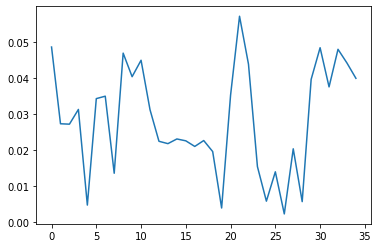

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', oob_score=True, random_state=8)
rfc.fit(data, labels)

print(rfc.oob_score_)
features_importance = rfc.feature_importances_
plt.plot(rfc.feature_importances_)

features_importance = np.array(features_importance)
arg_max = np.argsort(features_importance)

---
---
# **RandomForestClassifier with data separation and features selection**

In [ ]:
best_score = (0,0)
for number in range(1, n_features):

  arg_selected_features = arg_max[-number:]
  data_cut = data[:, arg_selected_features]

  rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', oob_score=True, random_state=8)
  rfc.fit(data_cut, labels)
  if rfc.oob_score_ > best_score[1]: best_score = (number, rfc.oob_score_)
  print("n_features =", number, "   out_of_box score:", rfc.oob_score_)

print("\nmeilleur score pour n_features =", best_score[0], "  oout of box score:", best_score[1])

n_features = 1    out_of_box score: 0.6435714285714286
n_features = 2    out_of_box score: 0.7410714285714286
n_features = 3    out_of_box score: 0.7939285714285714
n_features = 4    out_of_box score: 0.8128571428571428
n_features = 5    out_of_box score: 0.85
n_features = 6    out_of_box score: 0.8675
n_features = 7    out_of_box score: 0.8825
n_features = 8    out_of_box score: 0.8832142857142857
n_features = 9    out_of_box score: 0.88
n_features = 10    out_of_box score: 0.8875
n_features = 11    out_of_box score: 0.8882142857142857
n_features = 12    out_of_box score: 0.8957142857142857
n_features = 13    out_of_box score: 0.9
n_features = 14    out_of_box score: 0.905
n_features = 15    out_of_box score: 0.91
n_features = 16    out_of_box score: 0.9128571428571428
n_features = 17    out_of_box score: 0.9171428571428571
n_features = 18    out_of_box score: 0.9153571428571429
n_features = 19    out_of_box score: 0.9142857142857143
n_features = 20    out_of_box score: 0.914642857142

---
---
---
---
# **RFC with data separation and increment of data**

0.907


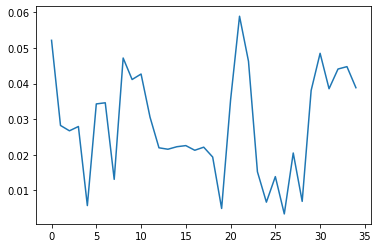

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', oob_score=True, random_state=8)
rfc.fit(data_incr, labels_incr)

print(rfc.oob_score_)
features_importance = rfc.feature_importances_
plt.plot(rfc.feature_importances_)

features_importance = np.array(features_importance)
arg_max = np.argsort(features_importance)

---
---
# **RandomForestClassifier with data separation and features selection and data increment**

In [ ]:
best_score = (0,0)
for number in range(1, n_features):

  arg_selected_features = arg_max[-number:]
  data_cut = data_incr[:, arg_selected_features]

  rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', oob_score=True, random_state=8)
  rfc.fit(data_cut, labels_incr)
  if rfc.oob_score_ > best_score[1]: best_score = (number, rfc.oob_score_)
  print("n_features =", number, "   out_of_box score:", rfc.oob_score_)

print("\nmeilleur score pour n_features =", best_score[0], "  oout of box score:", best_score[1])

n_features = 1    out_of_box score: 0.6433333333333333
n_features = 2    out_of_box score: 0.737
n_features = 3    out_of_box score: 0.7966666666666666
n_features = 4    out_of_box score: 0.8356666666666667
n_features = 5    out_of_box score: 0.8406666666666667
n_features = 6    out_of_box score: 0.8586666666666667
n_features = 7    out_of_box score: 0.8726666666666667
n_features = 8    out_of_box score: 0.8743333333333333
n_features = 9    out_of_box score: 0.877
n_features = 10    out_of_box score: 0.8876666666666667
n_features = 11    out_of_box score: 0.8973333333333333
n_features = 12    out_of_box score: 0.8996666666666666
n_features = 13    out_of_box score: 0.898
n_features = 14    out_of_box score: 0.9086666666666666
n_features = 15    out_of_box score: 0.9096666666666666
n_features = 16    out_of_box score: 0.9123333333333333
n_features = 17    out_of_box score: 0.9113333333333333
n_features = 18    out_of_box score: 0.9123333333333333
n_features = 19    out_of_box score: 0.9